In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
from zipfile import ZipFile

zip_files = "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/PPEs.v7-raw-images_ommittedsuitclasses.voc.zip"

with ZipFile(zip_files, 'r') as zip:
    zip.printdir()

    # extract files
    print('Extracting all the files now...')
    zip.extractall('/content/sample_data')

Streaming output truncated to the last 5000 lines.
valid/frame1246_jpg.rf.3c6218d5bf78c820d64cd52c68a19edc.xml 2022-10-30 16:22:30         1380
valid/frame1247_jpg.rf.abcc2371cf8f19d76317b95f2678d1da.jpg 2022-10-30 16:22:24       729085
valid/frame1247_jpg.rf.abcc2371cf8f19d76317b95f2678d1da.xml 2022-10-30 16:22:30         1380
valid/frame1248_jpg.rf.35e77cc4c884e99a1370f45031863970.jpg 2022-10-30 16:22:24       728875
valid/frame1248_jpg.rf.35e77cc4c884e99a1370f45031863970.xml 2022-10-30 16:22:30         1380
valid/frame1249_jpg.rf.61e6471db6c2f89b8bd5a47a54e90702.jpg 2022-10-30 16:22:26       728661
valid/frame1249_jpg.rf.61e6471db6c2f89b8bd5a47a54e90702.xml 2022-10-30 16:22:30         1380
valid/frame124_jpg.rf.3eb586c6172a16a5fbe0d90d6c1177b4.jpg 2022-10-30 16:22:24       339216
valid/frame124_jpg.rf.3eb586c6172a16a5fbe0d90d6c1177b4.xml 2022-10-30 16:22:30          868
valid/frame125--2-_jpg.rf.37a8fc900451a55831ee66adbcea8eaf.jpg 2022-10-30 16:22:24       716633
valid/frame125--2-

EDA

Melakukan explorasi terhadap dataset.

In [2]:
import glob
import os
from pathlib import Path
import random
import math
import yaml
import pandas as pd
import seaborn as sns

import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import shutil
from tqdm import tqdm

from IPython.display import HTML, display, Image
from base64 import b64encode
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image

Deklarasi kelas label

In [3]:
class_map = {0: 'glove', 1: 'goggles', 2: 'helmet', 3: 'mask', 4: 'no_glove', 5: 'no_goggles', 6: 'no_helmet', 7: 'no_mask', 8: 'no_shoes', 9: 'shoes'}

In [4]:
classes = ['glove', 'goggles', 'helmet', 'mask', 'no_glove', 'no_goggles', 'no_helmet', 'no_mask', 'no_shoes', 'shoes']


Jumlah frekuensi dataset

In [24]:
dataset_root = '/content/sample_data'
for subset_folder in ['train', 'valid', 'test']:
    subset_images = glob.glob(os.path.join(dataset_root, subset_folder, '*.jpg'))
    print(f"Number of {subset_folder} images:", len(subset_images))

Number of train images: 6473
Number of valid images: 3570
Number of test images: 1935


Contoh tampilan data train

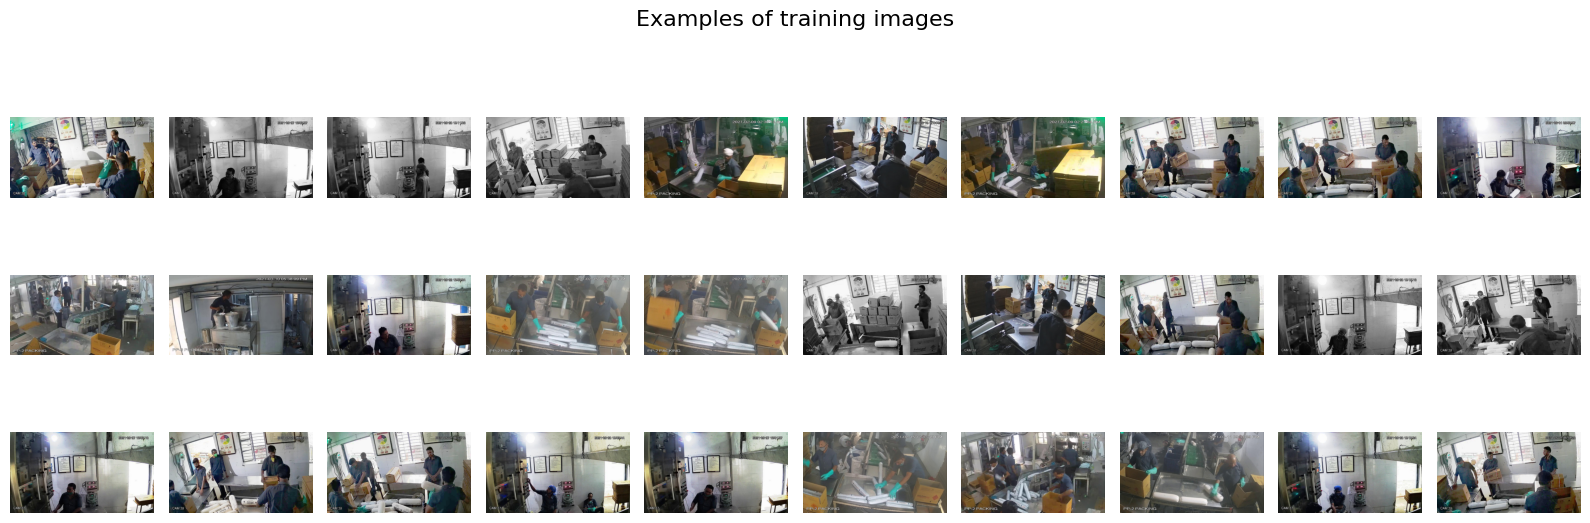

In [25]:
test_imgs_with_pred = glob.glob(os.path.join(dataset_root, 'train', '*.jpg'))

fig, axes = plt.subplots(3, 10, figsize=(16,6))
fig.suptitle('Examples of training images', fontsize=16)

# Random 15 image
selected_images = random.sample(test_imgs_with_pred, 30)
for i, ax in enumerate(axes.flatten()):
    image = cv2.imread(selected_images[i])
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax.imshow(image)
    ax.axis("off")

plt.tight_layout()
plt.show()

Memindahkan annotation file ke folder annotation, karena file image dan anotasi tergabung menjadi satu

In [ ]:
import shutil

def move_xml_files(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    image_folder = os.path.join(destination_folder, "image")
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)

    files = os.listdir(source_folder)

    for file in files:
        if file.endswith(".xml"):
            source_file = os.path.join(source_folder, file)
            destination_file = os.path.join(destination_folder, file)
            shutil.move(source_file, destination_file)
            print(f"{file} dipindahkan ke {destination_folder}")
        elif file.endswith(".jpg"):
            source_file = os.path.join(source_folder, file)
            destination_file = os.path.join(image_folder, file)
            shutil.move(source_file, destination_file)
            print(f"{file} dipindahkan ke {image_folder}")

source_train_xml = "/content/sample_data/train"
destination_train_xml = "/content/sample_data/train/destination_folder"
source_test_xml = "/content/sample_data/test"
destination_test_xml = "/content/sample_data/test/destination_folder"
source_valid_xml = "/content/sample_data/valid"
destination_valid_xml = "/content/sample_data/valid/destination_folder"

move_xml_files(source_train_xml, destination_train_xml)
move_xml_files(source_test_xml, destination_test_xml)
move_xml_files(source_valid_xml, destination_valid_xml)

Streaming output truncated to the last 5000 lines.
NX_img_27_jpg.rf.371de5fe9b22f5e0448864c13b8a5de7.xml dipindahkan ke /content/sample_data/test/destination_folder
helmet999542_jpg.rf.863050732f8ae18316929dd44bea517a.xml dipindahkan ke /content/sample_data/test/destination_folder
p11357_jpg.rf.77296cf0cab50469960f4e15a4e6b7bb.xml dipindahkan ke /content/sample_data/test/destination_folder
p11395_jpg.rf.94feb2573d4c34d74f17acaebf9dfffd.xml dipindahkan ke /content/sample_data/test/destination_folder
MX_img_28_jpg.rf.05e7c6c5f87cfdff8b52ea4e4c362acd.xml dipindahkan ke /content/sample_data/test/destination_folder
N5h_img_36_jpg.rf.67efb78d0b876475098b046de8c746b6.xml dipindahkan ke /content/sample_data/test/destination_folder
MX_img_182_jpg.rf.c5439c51eb59e50c2eca7ca56da4cdcb.xml dipindahkan ke /content/sample_data/test/destination_folder
frame115--2-_jpg.rf.75e2bd323a1bfa8977a5dd88f50ecbb4.xml dipindahkan ke /content/sample_data/test/destination_folder
frame1_jpg.rf.5ac2935c31a80b7b6a936

Instalasi library model

In [5]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 22790, done.
remote: Counting objects: 100% (716/716), done.
remote: Compressing objects: 100% (381/381), done.
remote: Total 22790 (delta 451), reused 539 (delta 334), pack-reused 22074
Receiving objects: 100% (22790/22790), 13.62 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (15868/15868), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.3/719.3 kB 4.6 MB/s eta 0:00:00


In [ ]:
import yaml

# configuration
config = {
   "train": "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/train",
   "val": "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/valid",
   "test": "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/test",
   "nc": 10,
   "names": ['glove', 'goggles', 'helmet', 'mask', 'no_glove', 'no_goggles', 'no_helmet', 'no_mask', 'no_shoes', 'shoes']
}
with open("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/data5.yaml", "w+") as file:
   yaml.dump(config, file)

Data Preparation

In [6]:
nc = 10

In [26]:
class_idx = {str(i):classes[i] for i in range(nc)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(nc)}

    path = os.path.join("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset", mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

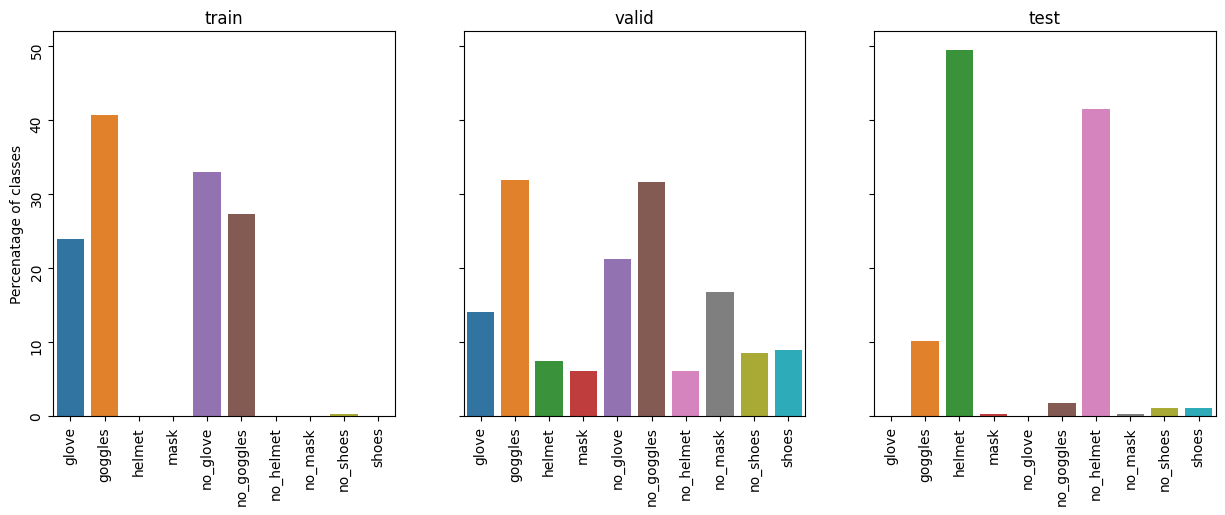

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

Nampak data train tidak cukup lengkap, menghandle keseluruhan kelas label

Normalisasi data

In [ ]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset", mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


Sebelumnya dataset tidak memiliki ukuran size yang sama, namun saya lakukan resize untuk menormalisasi ukuran size, menggunakan kode dibawah ini. Sehigga ketika dimuat ulang dataset sudah berubah menjadi ukuran yang sama

In [ ]:
target_size = (640, 640)

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    for file in glob.glob(os.path.join("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset", mode, 'images', '*')):
        image = Image.open(file)
        resized_image = image.resize(target_size, Image.ANTIALIAS)
        resized_image.save(file)
        print(f'\t{resized_image.size}')


Image sizes in train set:



<ipython-input-23-3565ccb94645>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


Streaming output truncated to the last 5000 lines.
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	(640, 640)
	

In [ ]:
for mode in ['train', 'valid', 'test']:

    files =  glob.glob(os.path.join("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset", mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')

train set size: 4150

valid set size: 771

test set size: 1935



Mempertimbangkan dari kurang baiknya persebaran data pada data train, saya memutuskan hanya menggunakan data valid dalam ujicoba ini. Data valid memiliki persebaran yang baik pada setiap kelas label nya, sehingga saya melakukan random split menjadi tiga kelas baru, yaitu train, valid , dan test

Proses pembersihan dan split data

In [ ]:
import os
from PIL import Image

dataset_dir = "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/valid/images"
hashes = {}
duplicate_files = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        image_path = os.path.join(root, file)
        with Image.open(image_path) as img:
            img_hash = img.tobytes()
            if img_hash in hashes:
                duplicate_files.append(image_path)
            else:
                hashes[img_hash] = image_path

for file_path in duplicate_files:
    os.remove(file_path)

print(f"{len(duplicate_files)} duplikat gambar telah dihapus.")

0 duplikat gambar telah dihapus.


In [ ]:
import os

dataset_dir = "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/valid/images"
files = os.listdir(dataset_dir)

for file_name in files:
    if "(1)" in file_name:
        new_file_name = file_name.replace("(1)", "")
        os.rename(os.path.join(dataset_dir, file_name), os.path.join(dataset_dir, new_file_name))
        print(f"Nama file {file_name} telah diubah menjadi {new_file_name}")

In [ ]:
import os
import shutil

dataset_dir = "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset"
new_dataset_dir = "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new"

train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

def create_subset(subset):
    subset_dir = os.path.join(new_dataset_dir, subset)
    os.makedirs(os.path.join(subset_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(subset_dir, 'labels'), exist_ok=True)
    return subset_dir

os.makedirs(new_dataset_dir, exist_ok=True)
mode = 'valid'

files = glob.glob(os.path.join(dataset_dir, mode, 'images', '*'))
random.shuffle(files)

total_files = len(files)
train_count = int(total_files * train_ratio)
valid_count = int(total_files * valid_ratio)
test_count = total_files - train_count - valid_count

train_dir = create_subset('train')
valid_dir = create_subset('valid')
test_dir = create_subset('test')

for i, file in enumerate(files):
    if i < train_count:
        subset_dir = train_dir
    elif i < train_count + valid_count:
        subset_dir = valid_dir
    else:
        subset_dir = test_dir

    shutil.copy(file, os.path.join(subset_dir, 'images'))
    label_file = file.replace('images', 'labels').replace('.jpg', '.txt')
    shutil.copy(label_file, os.path.join(subset_dir, 'labels'))

print("Dataset baru telah dibuat di:", new_dataset_dir)


Dataset baru telah dibuat di: /content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new


Hasil sebaran data setelah dilakukan normalisasi data

In [7]:
class_idx = {str(i):classes[i] for i in range(nc)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(nc)}

    path = os.path.join("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new", mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

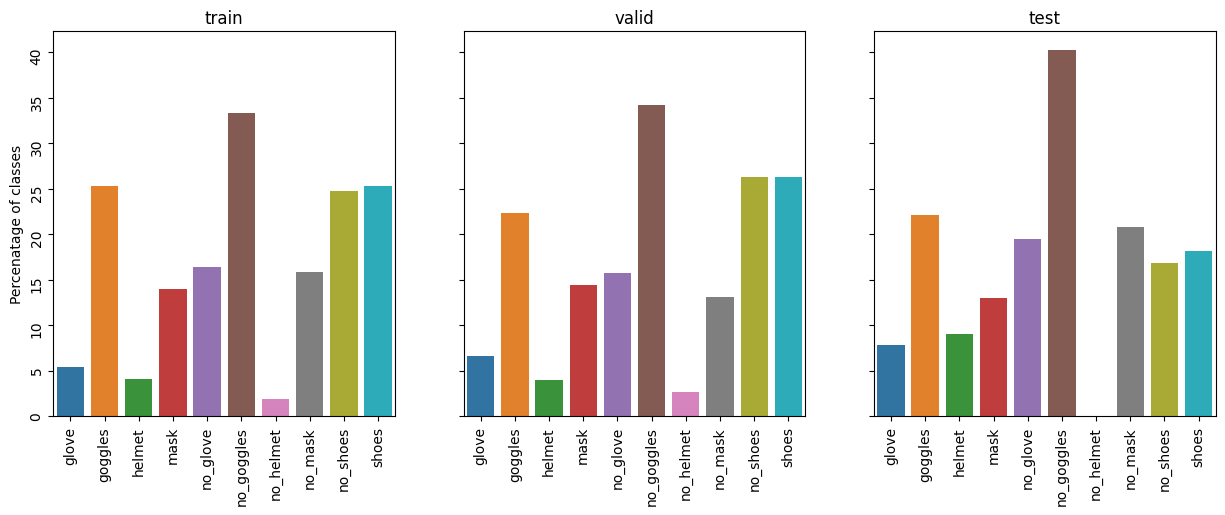

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

Jumlah data yang digunakan dalam pembuatan model maupun ujicoba

In [9]:
for mode in ['train', 'valid', 'test']:

    files =  glob.glob(os.path.join("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new", mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')

train set size: 726

valid set size: 76

test set size: 77



Pembuatan model YOLO

In [10]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 76.4MB/s]


Pembuatan label cache baru karena hilang

In [ ]:
label_dir = "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/train/labels"
label_files = glob.glob(os.path.join(label_dir, "*.txt"))

labels = []
for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        labels.extend(lines)

labels_array = np.array(labels)

cache_file = "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/train/labels.cache.npy"
np.save(cache_file, labels_array)

print("File labels.cache.npy telah berhasil dibuat.")


File labels.cache.npy telah berhasil dibuat.


Training data dengan yolo

In [11]:
import yaml

# configuration
config = {
   "train": "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/train",
   "val": "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/valid",
   "test": "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/test",
   "nc": 10,
   "names": ['glove', 'goggles', 'helmet', 'mask', 'no_glove', 'no_goggles', 'no_helmet', 'no_mask', 'no_shoes', 'shoes']
}
with open("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/data1.yaml", "w+") as file:
   yaml.dump(config, file)

In [12]:
model.train(data=os.path.join("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new",'data1.yaml'),
            task='detect',
            imgsz=640,
            epochs=10,
            batch=16,
            mode='train',
            name='yolov8n_v2_train')

Ultralytics YOLOv8.1.23 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/data1.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v2_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False

100%|██████████| 755k/755k [00:00<00:00, 16.3MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/train/labels.cache... 724 images, 12 backgrounds, 0 corrupt: 100%|██████████| 726/726 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/valid/labels.cache... 76 images, 0 backgrounds, 0 corrupt: 100%|██████████| 76/76 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_v2_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_v2_train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.43G      2.104      5.081      1.491          6        640: 100%|██████████| 46/46 [00:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         76        180    0.00635      0.322      0.266      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.29G      1.648      2.929       1.23         12        640: 100%|██████████| 46/46 [00:18<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


                   all         76        180       0.78      0.197      0.562       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.29G      1.478      2.346      1.161          7        640: 100%|██████████| 46/46 [00:16<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         76        180      0.763      0.586       0.69      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.29G      1.403      1.905      1.128         10        640: 100%|██████████| 46/46 [00:17<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         76        180      0.734      0.742      0.752      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.29G       1.31      1.713      1.111         10        640: 100%|██████████| 46/46 [00:17<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         76        180       0.88      0.734      0.826      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.29G      1.231      1.554      1.068          8        640: 100%|██████████| 46/46 [00:16<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         76        180      0.798      0.837      0.839      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.28G      1.228      1.462      1.065         14        640: 100%|██████████| 46/46 [00:18<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         76        180      0.768      0.854      0.871      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.28G      1.149      1.356      1.036         10        640: 100%|██████████| 46/46 [00:16<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         76        180      0.758      0.907      0.892      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.28G      1.106      1.285      1.031         11        640: 100%|██████████| 46/46 [00:17<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         76        180      0.846      0.881      0.907       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.28G      1.067      1.245       1.01         13        640: 100%|██████████| 46/46 [00:16<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


                   all         76        180      0.848      0.887      0.912      0.622

10 epochs completed in 0.061 hours.
Optimizer stripped from runs/detect/yolov8n_v2_train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_v2_train/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_v2_train/weights/best.pt...
Ultralytics YOLOv8.1.23 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


                   all         76        180      0.848      0.887      0.912      0.622
                 glove         76         16      0.754          1      0.914       0.51
               goggles         76         17          1      0.898      0.992      0.709
                helmet         76          5      0.822      0.933      0.895      0.446
                  mask         76         11        0.9          1      0.995      0.712
              no_glove         76         14       0.81      0.916      0.869      0.461
            no_goggles         76         26      0.976          1      0.995      0.684
             no_helmet         76          4      0.584       0.25      0.517      0.307
               no_mask         76         10      0.893        0.9      0.968      0.698
              no_shoes         76         37      0.952          1      0.995      0.813
                 shoes         76         40      0.792      0.975      0.977      0.877
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc34b8eb580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

Test Model

In [14]:
model = YOLO('/content/runs/detect/yolov8n_v2_train/weights/best.pt')

In [15]:
results = model.predict(source=os.path.join('/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new', 'test', 'images'), save=True)


image 1/77 /content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/test/images/005315_jpg.rf.0c2cc89ab9f73bcff34cabd1ade31e7a.jpg: 640x640 1 helmet, 2 no_helmets, 12.7ms
image 2/77 /content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/test/images/005373_jpg.rf.faefe6192f8b0a737810899fed657a01.jpg: 640x640 6 helmets, 8.4ms
image 3/77 /content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/test/images/005448_jpg.rf.f73afed71b90763a669dc0a9f4679a99.jpg: 640x640 3 helmets, 9.2ms
image 4/77 /content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/test/images/005469_jpg.rf.b87787ca18c90d7d2bc238a5a6633939.jpg: 640x640 1 helmet, 1 no_glove, 8.3ms
image 5/77 /content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/test/images/005533_jpg.rf.6b6d1ccd8d851deb2c32e8c7f7110440.jpg: 640x640 1 helmet, 8.1ms
image 6/77 /content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/test/images/005534_jpg.rf.36e42ba2de0a84631cb994a93ed293cb.jpg: 640x640 1 helmet, 1 no

Prediksi terhadap data gambar

In [18]:
%matplotlib inline

predicitions = glob.glob(os.path.join("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new", 'runs/detect/predict', '*'))

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Evaluasi dari proses pembuatan model

In [21]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

In [29]:
results_paths = [
    i for i in
    glob.glob(f'/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/confusion_matrix_normalized.png')+
    glob.glob(f'/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/confusion_matrix.png') +
    glob.glob(f'/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/F1_curve.png') +
    glob.glob(f'/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/PR_curve.png') +
    glob.glob(f'/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/P_curve.png') +
    glob.glob(f'/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/R_curve.png') +
    glob.glob(f'/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/results.png')


    if 'batch' not in i
]

results_paths

['/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/confusion_matrix_normalized.png',
 '/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/confusion_matrix.png',
 '/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/F1_curve.png',
 '/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/PR_curve.png',
 '/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/P_curve.png',
 '/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/R_curve.png',
 '/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/results.png']

/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/F1_curve.png


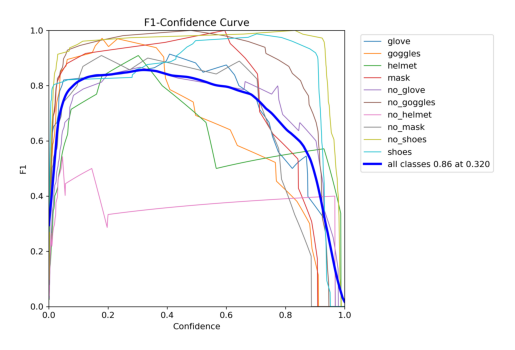



/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/PR_curve.png


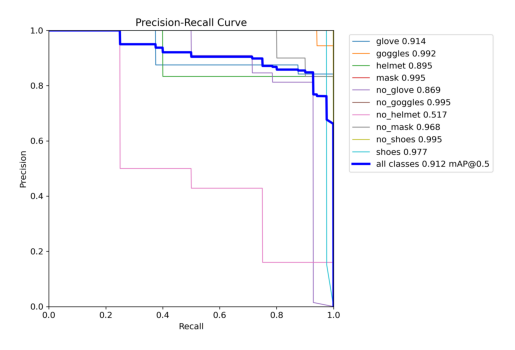



/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/P_curve.png


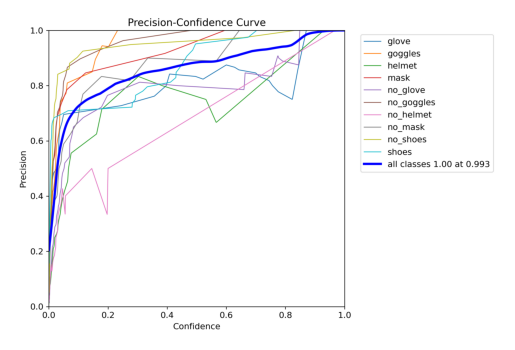



/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/R_curve.png


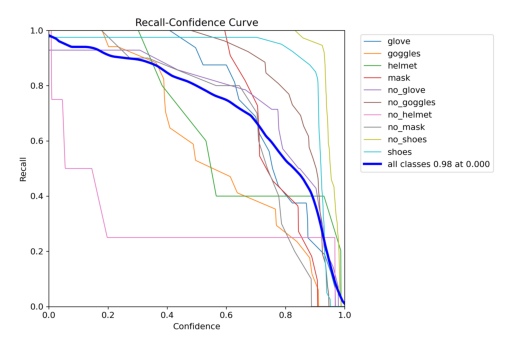



/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/confusion_matrix.png


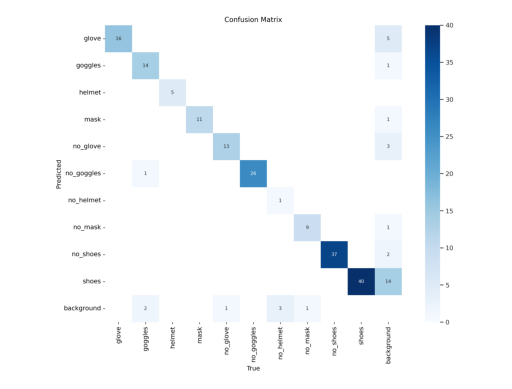



/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/confusion_matrix_normalized.png


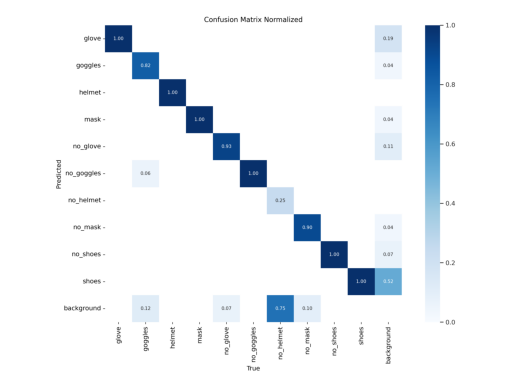



/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new/runs/detect/yolov8n_v2_train/results.png


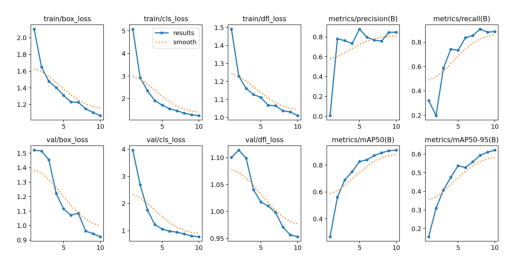

In [30]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

Berdasarkan hasil evaluasi menunjukkan bahwa model semakin baik dalam memahami dan mendeteksi objek pada data, hal ini dilihat pada setiap epoch nya kehilangan box loss mengalami penurunan, sedangkan presisi, recall, da mAP50 meningkat.

Menyimpan hasil ujicoba

In [17]:
import shutil

source_dir = "/content/runs"
destination_dir = "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset_new"


shutil.move(source_dir, destination_dir)

print("Folder runs berhasil dipindahkan ke lokasi baru.")

Folder runs berhasil dipindahkan ke lokasi baru.
